## Steps:

1. Custom CNN for Feature Extraction
2. Texture Analysis using GLCM
3. Saving Features to CSV
4. Training an ANN Model
5. Model Evaluation Function

In [1]:
# libs
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.feature import greycomatrix, greycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Custom CNN Model for Feature Extraction
def create_custom_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

# Experiment failed
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = layers.GlobalAveragePooling2D()(x)

    
    model = models.Model(inputs, x)
    
    model.summary()
    
    return model

In [3]:
# Step 2: Function to calculate GLCM properties
def calculate_glcm_features(image, distances, angles):
    properties = ['contrast', 'dissimilarity', 'homogeneity', 
                  'energy', 'correlation', 'ASM']
    glcm = greycomatrix(image, 
                        distances = distances, 
                        angles = angles,
#                         levels = 256,
                        symmetric = True, 
                        normed = True)
    feature_vector = []
    
    for prop in properties:
        prop_values = greycoprops(glcm, prop)
        feature_vector.extend(prop_values.flatten())
    
    return feature_vector

In [4]:
# Step 3: Fetch CNN features, GLCM features, and save to CSV
def extract_features_and_save(images, labels, cnn_model, output_csv, distances, angles):
    feature_list = []
    for i, image in enumerate(images):
        print(f"Processing image {i+1}/{len(images)}")
        
        # CNN Features
        image_expanded = np.expand_dims(image, axis=0)  # Expand dimensions for the CNN model
        cnn_features = cnn_model.predict(image_expanded).flatten()
        
        # GLCM Features
        image_gray = np.mean(image, axis=-1).astype(np.uint8)  # Convert to grayscale if needed
        glcm_features = calculate_glcm_features(image_gray, distances, angles)
        
        # Combine CNN + GLCM features
        combined_features = np.concatenate([cnn_features, glcm_features])
        feature_list.append(np.concatenate([combined_features, [int(labels[i])]]))
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame(feature_list)
#     df['col1'] = df['col1'].astype(int)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

In [5]:
# Step 4: Create ANN model to train using extracted features
def create_ann_model(input_dim, num_class):
    model = models.Sequential([
        layers.Dense(1024, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        #layers.Dense(num_class, activation='sigmoid')  # Adjust depending on the classification task (binary/multi-class)
        layers.Dense(num_class, activation='softmax')  # Adjust depending on the classification task (binary/multi-class)
    ])
    
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss if multi-class
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adjust loss if multi-class
    
    model.summary()
    
    return model

In [6]:
# Step 5: Function to evaluate ANN model
def evaluate_model(model, X_test, y_test, class_names=None):
    #y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Binary thresholding for binary classification
    #print(classification_report(y_test, y_pred))
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get class with highest probability
    y_true = y_test # np.argmax(y_test, axis=1)  # Convert one-hot to labels for classification report
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true, y_pred)
    
    # Get classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    
    # Calculate Cohen's kappa score
    kappa_score = cohen_kappa_score(y_true, y_pred)
    
    # Print evaluation metrics
    print(f"\nAccuracy Score: {accuracy * 100:.2f}%")
    print(f"Loss Score: {(1- accuracy) * 100:.2f}%")
    print(f"Cohen's Kappa Score: {kappa_score * 100:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", class_report)
    
    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    try:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    except Exception as e:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
#     print(classification_report(y_true, y_pred))

In [7]:
# Step 6: Load your dataset
# def load_dataset_from_directory(directory, img_size=(224, 224), batch_size=32):
#     dataset = tf.keras.utils.image_dataset_from_directory(
#         directory,
#         labels = 'inferred',
#         label_mode = 'categorical',  # 'int' for integer labels, change to 'categorical' if needed
#         image_size = img_size,  # Resize all images to the target size
#         batch_size = batch_size,
#         shuffle = True
#     )
    
#     return dataset

def load_dataset_from_directory(base_dir, image_size=(128, 128)):
    """
    Load images and labels from a directory.

    Args:
        base_dir (str): Path to the base directory containing class subdirectories.
        image_size (tuple): Target size to resize images (default: (128, 128)).

    Returns:
        tuple: (images, labels, class_names)
               - images: numpy array of images
               - labels: numpy array of labels
               - class_names: list of class names (ordered by directory names)
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))  # Class names sorted alphabetically
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        
        if not os.path.isdir(class_dir):
            continue
        
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                # Open and preprocess the image
                img = Image.open(file_path).convert('RGB')  # Convert to RGB
                img = img.resize(image_size)  # Resize image to target size
                images.append(np.array(img))  # Convert image to numpy array
                labels.append(label)  # Append corresponding label
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize pixel values to [0, 1]
    labels = np.array(labels, dtype='int')

    return images, labels, class_names

In [8]:
# !pip install split-folders

# import os
# import splitfolders

# splitfolders.ratio(os.path.join('..', 'Dataset', 'Malignant_Lymphoma_Classification'),
#                    os.path.join('..', 'Dataset', 'Malignant_Lymphoma_Classification_data'),
#                    seed = 41,
#                    ratio = (0.6, 0.25, 0.15)) # train/val/test

Loaded 374 images.
Class names: ['CLL', 'FL', 'MCL']
Labels: [0 1 2]
Images of shape (224, 224, 3)
Loaded 374 labels


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
        

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 3/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 145ms/step
Processing image 4/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 5/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 6/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 134ms/step
Processing image 7/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 8/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 9/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 10/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 11/374
1/1 [==============================] - 0s 122ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 12/374
1/1 [==============================] - 0s 128ms/step
Processing image 13/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 14/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 15/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 151ms/step
Processing image 16/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 17/374
1/1 [==============================] - 0s 123ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 18/374
1/1 [==============================] - 0s 124ms/step
Processing image 19/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 20/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 121ms/step
Processing image 21/374
1/1 [==============================] - 0s 116ms/step
Processing image 22/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 110ms/step
Processing image 23/374
1/1 [==============================] - 0s 109ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 24/374
1/1 [==============================] - 0s 111ms/step
Processing image 25/374
1/1 [==============================] - 0s 114ms/step
Processing image 26/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 27/374
1/1 [==============================] - 0s 111ms/step
Processing image 28/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 113ms/step
Processing image 29/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 204ms/step
Processing image 30/374
1/1 [==============================] - 0s 124ms/step
Processing image 31/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 32/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 33/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 34/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 35/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 36/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 37/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 38/374
1/1 [==============================] - 0s 119ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 39/374
1/1 [==============================] - 0s 124ms/step
Processing image 40/374
1/1 [==============================] - 0s 124ms/step
Processing image 41/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 42/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 43/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 142ms/step
Processing image 44/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 45/374
1/1 [==============================] - 0s 126ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 46/374
1/1 [==============================] - 0s 126ms/step
Processing image 47/374
1/1 [==============================] - 0s 126ms/step
Processing image 48/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 127ms/step
Processing image 49/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 50/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 134ms/step
Processing image 51/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 52/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 53/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 54/374
1/1 [==============================] - 0s 125ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 55/374
1/1 [==============================] - 0s 132ms/step
Processing image 56/374
1/1 [==============================] - 0s 124ms/step
Processing image 57/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 150ms/step
Processing image 58/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 59/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 60/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 61/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 62/374
1/1 [==============================] - 0s 116ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 63/374
1/1 [==============================] - 0s 124ms/step
Processing image 64/374
1/1 [==============================] - 0s 109ms/step
Processing image 65/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 176ms/step
Processing image 66/374
1/1 [==============================] - 0s 124ms/step
Processing image 67/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 126ms/step
Processing image 68/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 69/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 118ms/step
Processing image 70/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 173ms/step
Processing image 71/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 162ms/step
Processing image 72/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 250ms/step
Processing image 73/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 174ms/step
Processing image 74/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 187ms/step
Processing image 75/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 181ms/step
Processing image 76/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 77/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 189ms/step
Processing image 78/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 222ms/step
Processing image 79/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 177ms/step
Processing image 80/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 164ms/step
Processing image 81/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 153ms/step
Processing image 82/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 161ms/step
Processing image 83/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 84/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 135ms/step
Processing image 85/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 86/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 225ms/step
Processing image 87/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 247ms/step
Processing image 88/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 270ms/step
Processing image 89/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 150ms/step
Processing image 90/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 91/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 118ms/step
Processing image 92/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 93/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 160ms/step
Processing image 94/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 95/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 192ms/step
Processing image 96/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 164ms/step
Processing image 97/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 98/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 120ms/step
Processing image 99/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 100/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 123ms/step
Processing image 101/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 102/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 142ms/step
Processing image 103/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 104/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 105/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 106/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 107/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 108/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 146ms/step
Processing image 109/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 110/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 111/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 112/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 113/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 114/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 117ms/step
Processing image 115/374
1/1 [==============================] - 0s 118ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 116/374
1/1 [==============================] - 0s 116ms/step
Processing image 117/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 118/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 119/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 115ms/step
Processing image 120/374
1/1 [==============================] - 0s 113ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 121/374
1/1 [==============================] - 0s 119ms/step
Processing image 122/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 123/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 124/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 120ms/step
Processing image 125/374
1/1 [==============================] - 0s 116ms/step
Processing image 126/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 119ms/step
Processing image 127/374
1/1 [==============================] - 0s 128ms/step
Processing image 128/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 130ms/step
Processing image 129/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 130/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 131/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 115ms/step
Processing image 132/374
1/1 [==============================] - 0s 117ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 133/374
1/1 [==============================] - 0s 131ms/step
Processing image 134/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 135/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 136/374
1/1 [==============================] - 0s 118ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 137/374
1/1 [==============================] - 0s 126ms/step
Processing image 138/374
1/1 [==============================] - 0s 123ms/step
Processing image 139/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 130ms/step
Processing image 140/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 117ms/step
Processing image 141/374
1/1 [==============================] - 0s 117ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 142/374
1/1 [==============================] - 0s 125ms/step
Processing image 143/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 144/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 139ms/step
Processing image 145/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 115ms/step
Processing image 146/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 147/374
1/1 [==============================] - 0s 118ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 148/374
1/1 [==============================] - 0s 126ms/step
Processing image 149/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 150/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 151ms/step
Processing image 151/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 174ms/step
Processing image 152/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 162ms/step
Processing image 153/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 154/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 160ms/step
Processing image 155/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 156/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 157/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 158/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 117ms/step
Processing image 159/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 115ms/step
Processing image 160/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 151ms/step
Processing image 161/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 167ms/step
Processing image 162/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 158ms/step
Processing image 163/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 156ms/step
Processing image 164/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 145ms/step
Processing image 165/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 166/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 166ms/step
Processing image 167/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 142ms/step
Processing image 168/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 169/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 170/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 144ms/step
Processing image 171/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 172/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 173/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 280ms/step
Processing image 174/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 165ms/step
Processing image 175/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 134ms/step
Processing image 176/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 177/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 150ms/step
Processing image 178/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 179/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 184ms/step
Processing image 180/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 189ms/step
Processing image 181/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 165ms/step
Processing image 182/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 183/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 123ms/step
Processing image 184/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 185/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 186/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 144ms/step
Processing image 187/374
1/1 [==============================] - 0s 119ms/step
Processing image 188/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 116ms/step
Processing image 189/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 190/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 191/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 139ms/step
Processing image 192/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 193/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 154ms/step
Processing image 194/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 140ms/step
Processing image 195/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 177ms/step
Processing image 196/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 163ms/step
Processing image 197/374
1/1 [==============================] - 0s 116ms/step
Processing image 198/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 121ms/step
Processing image 199/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 200/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 144ms/step
Processing image 201/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 140ms/step
Processing image 202/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 203/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 204/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 205/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 285ms/step
Processing image 206/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 232ms/step
Processing image 207/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 196ms/step
Processing image 208/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 178ms/step
Processing image 209/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 198ms/step
Processing image 210/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 190ms/step
Processing image 211/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 220ms/step
Processing image 212/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 209ms/step
Processing image 213/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 157ms/step
Processing image 214/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 141ms/step
Processing image 215/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 147ms/step
Processing image 216/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 194ms/step
Processing image 217/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 218/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 224ms/step
Processing image 219/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 163ms/step
Processing image 220/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 154ms/step
Processing image 221/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 218ms/step
Processing image 222/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 159ms/step
Processing image 223/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step
Processing image 224/374
1/1 [==============================] - 0s 119ms/step
Processing image 225/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 226/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 227/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 135ms/step
Processing image 228/374
1/1 [==============================] - 0s 111ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 229/374
1/1 [==============================] - 0s 122ms/step
Processing image 230/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 188ms/step
Processing image 231/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 232/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 123ms/step
Processing image 233/374
1/1 [==============================] - 0s 120ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 234/374
1/1 [==============================] - 0s 135ms/step
Processing image 235/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 236/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 144ms/step
Processing image 237/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 155ms/step
Processing image 238/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 119ms/step
Processing image 239/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 114ms/step
Processing image 240/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 123ms/step
Processing image 241/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 242/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 243/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 159ms/step
Processing image 244/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 191ms/step
Processing image 245/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 148ms/step
Processing image 246/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 247/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 248/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 147ms/step
Processing image 249/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 163ms/step
Processing image 250/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 189ms/step
Processing image 251/374
1/1 [==============================] - 0s 115ms/step
Processing image 252/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 123ms/step
Processing image 253/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 254/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 157ms/step
Processing image 255/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 179ms/step
Processing image 256/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 115ms/step
Processing image 257/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 258/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 259/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 191ms/step
Processing image 260/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 121ms/step
Processing image 261/374
1/1 [==============================] - 0s 116ms/step
Processing image 262/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 159ms/step
Processing image 263/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 187ms/step
Processing image 264/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 189ms/step
Processing image 265/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 266/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 152ms/step
Processing image 267/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 175ms/step
Processing image 268/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 169ms/step
Processing image 269/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 270/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 271/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 155ms/step
Processing image 272/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 273/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 119ms/step
Processing image 274/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 275/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 276/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 277/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 278/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 279/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 280/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 134ms/step
Processing image 281/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 282/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 117ms/step
Processing image 283/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 284/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 285/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 185ms/step
Processing image 286/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 147ms/step
Processing image 287/374
1/1 [==============================] - 0s 117ms/step
Processing image 288/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 168ms/step
Processing image 289/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 290/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 146ms/step
Processing image 291/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 292/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 123ms/step
Processing image 293/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 135ms/step
Processing image 294/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 295/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 141ms/step
Processing image 296/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 119ms/step
Processing image 297/374
1/1 [==============================] - 0s 118ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 298/374
1/1 [==============================] - 0s 131ms/step
Processing image 299/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 300/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 301/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 138ms/step
Processing image 302/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 303/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 139ms/step
Processing image 304/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 305/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 306/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 118ms/step
Processing image 307/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 308/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 309/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 131ms/step
Processing image 310/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 311/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 312/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 129ms/step
Processing image 313/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 314/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 162ms/step
Processing image 315/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 316/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 122ms/step
Processing image 317/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 318/374
1/1 [==============================] - 0s 126ms/step
Processing image 319/374

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica


1/1 [==============================] - 0s 132ms/step
Processing image 320/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 321/374
1/1 [==============================] - 0s 117ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 322/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 323/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 133ms/step
Processing image 324/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 325/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 117ms/step
Processing image 326/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 116ms/step
Processing image 327/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 328/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 134ms/step
Processing image 329/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 140ms/step
Processing image 330/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 118ms/step
Processing image 331/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 118ms/step
Processing image 332/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 333/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 334/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 335/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 143ms/step
Processing image 336/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 156ms/step
Processing image 337/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 168ms/step
Processing image 338/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 155ms/step
Processing image 339/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 340/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 136ms/step
Processing image 341/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 126ms/step
Processing image 342/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 343/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 344/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 113ms/step
Processing image 345/374
1/1 [==============================] - 0s 120ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 346/374
1/1 [==============================] - 0s 124ms/step
Processing image 347/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 348/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 349/374
1/1 [==============================] - 0s 113ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 350/374
1/1 [==============================] - 0s 116ms/step
Processing image 351/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 352/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 353/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 354/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 141ms/step
Processing image 355/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 356/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 357/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 127ms/step
Processing image 358/374
1/1 [==============================] - 0s 115ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Processing image 359/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 121ms/step
Processing image 360/374
1/1 [==============================] - 0s 127ms/step
Processing image 361/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 125ms/step
Processing image 362/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 140ms/step
Processing image 363/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 364/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 128ms/step
Processing image 365/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 130ms/step
Processing image 366/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 124ms/step
Processing image 367/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 132ms/step
Processing image 368/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 147ms/step
Processing image 369/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 152ms/step
Processing image 370/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 173ms/step
Processing image 371/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 175ms/step
Processing image 372/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 145ms/step
Processing image 373/374
1/1 [==============================] - ETA: 0s

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 137ms/step
Processing image 374/374


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

1/1 [==============================] - 0s 149ms/step


C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multica

Features saved to ..\Dataset\CNN_GLCM_features.csv
X_train.shape[1] : 2054

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2104320   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2385347 (9.10 MB)
Trainable params: 2385347 (9.10 MB)
Non-trainable params: 0 (0.00 Byte)
________

Epoch 45/100
9/9 [==============================] - 0s 48ms/step - loss: 0.9844 - accuracy: 0.4833 - val_loss: 0.9961 - val_accuracy: 0.3667
Epoch 46/100
9/9 [==============================] - 0s 50ms/step - loss: 0.9179 - accuracy: 0.5390 - val_loss: 0.8580 - val_accuracy: 0.4667
Epoch 47/100
9/9 [==============================] - 0s 43ms/step - loss: 0.8745 - accuracy: 0.5353 - val_loss: 0.8854 - val_accuracy: 0.4667
Epoch 48/100
9/9 [==============================] - 0s 42ms/step - loss: 0.8830 - accuracy: 0.5316 - val_loss: 0.8578 - val_accuracy: 0.5333
Epoch 49/100
9/9 [==============================] - 0s 42ms/step - loss: 0.8640 - accuracy: 0.5167 - val_loss: 0.8472 - val_accuracy: 0.5000
Epoch 50/100
9/9 [==============================] - 0s 44ms/step - loss: 0.9243 - accuracy: 0.5316 - val_loss: 0.8416 - val_accuracy: 0.5000
Epoch 51/100
9/9 [==============================] - 0s 56ms/step - loss: 0.8893 - accuracy: 0.5279 - val_loss: 0.8579 - val_accuracy: 0.5000
Epoch 52/100


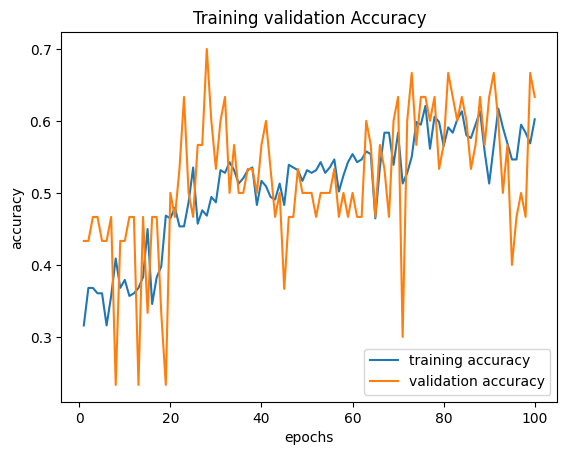

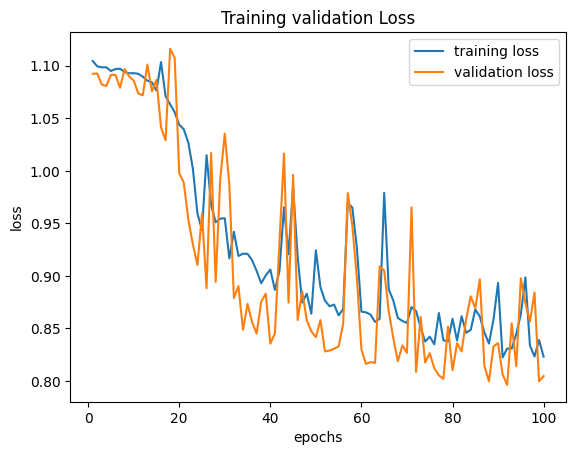

3/3 [==============================] - 0s 7ms/step

Accuracy Score: 60.00%
Loss Score: 40.00%
Cohen's Kappa Score: 39.0079
Confusion Matrix:
 [[13  5  5]
 [ 1 24  3]
 [ 6 10  8]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.57      0.60        23
         1.0       0.62      0.86      0.72        28
         2.0       0.50      0.33      0.40        24

    accuracy                           0.60        75
   macro avg       0.59      0.59      0.57        75
weighted avg       0.59      0.60      0.58        75



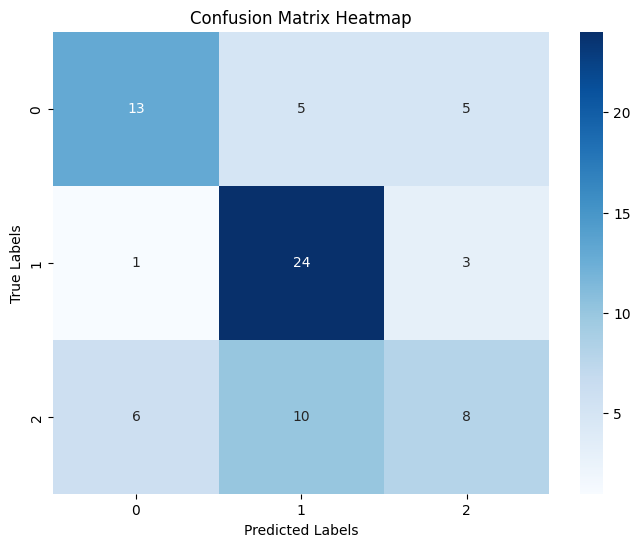

In [9]:

if __name__ == "__main__":
    # Step 6: Load your dataset
    # Load training data
    train_directory = os.path.join('..', 'Dataset', 'Malignant_Lymphoma_Classification')
    images, labels, class_names = load_dataset_from_directory(train_directory, image_size=(224, 224))
    print(f"Loaded {len(images)} images.")
    print(f"Class names: {class_names}")
    print(f"Labels: {np.unique(labels)}")    
    print(f"Images of shape {images.shape[1:]}")
    print(f"Loaded {labels.shape[0]} labels")

    # Step 7: CNN Model for feature extraction
    cnn_model = create_custom_cnn(input_shape=(224, 224, 3))
    
    # Step 8: GLCM parameters
    distances = [1] # [1, 3, 5, 3, 1, 3, 5]
    angles = [0] # [0, 0, 0, np.pi/4, np.pi/2, np.pi/2, np.pi/2]

    # Step 9: Extract features and save to CSV
    output_csv = os.path.join('..', 'Dataset', 'CNN_GLCM_features.csv')
    extract_features_and_save(images, labels, cnn_model, output_csv, distances, angles)

    # Step 10: Load CSV and prepare for ANN training
    data = pd.read_csv(output_csv)
    
    X = data.iloc[:, :-1].values  # All columns except the last one (features)
    y = data.iloc[:, -1].values  # Last column (labels)
#     print(X, y)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"X_train.shape[1] : {X_train.shape[1]}")
    
    # Step 11: Create and train ANN
    ann_model = create_ann_model(input_dim=X_train.shape[1], num_class=len(class_names))
    history = ann_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.show()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.show()

    # Step 12: Evaluate the model
    evaluate_model(ann_model, X_test, y_test)

    